<a href="https://colab.research.google.com/github/Salahbendary/Network-Packet-Analysis-with-Python/blob/main/Network_Packet_Analysis_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and Installation


In [1]:
# Install necessary packages
!pip install dpkt
!pip install seaborn
!pip install pandas
!pip install matplotlib
!pip install tqdm


# Import Libraries


In [2]:
import dpkt
import pandas as pd
import seaborn as sns
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
import socket
import struct


# Import Data

In [3]:
# Import the necessary library to upload files
from google.colab import files

# Upload files to Google Colab
uploaded = files.upload()

# List the uploaded files
pcap_files = list(uploaded.keys())

# Display the list of files
print("Uploaded PCAP files:", pcap_files)


Saving sip-rtp-g729a.pcap to sip-rtp-g729a (2).pcap
Saving sip-rtp-l16.pcap to sip-rtp-l16 (2).pcap
Saving sip-rtp-lpc.pcap to sip-rtp-lpc (2).pcap
Saving sip-rtp-opus.pcap to sip-rtp-opus (1).pcap
Saving sip-rtp-gsm.pcap to sip-rtp-gsm (2).pcap
Saving sip-rtp-ilbc.pcap to sip-rtp-ilbc (1).pcap
Saving sip-rtp-g726.pcap to sip-rtp-g726 (1).pcap
Saving sip-rtp-g722.pcap to sip-rtp-g722 (1).pcap
Saving sip-rtp-dvi4.pcap to sip-rtp-dvi4 (1).pcap
Saving sip-rtp-g711.pcap to sip-rtp-g711 (1).pcap
Saving rtp-opus-only.pcap to rtp-opus-only (1).pcap
Saving MagicJack-_short_call.pcap to MagicJack-_short_call (1).pcap
Saving sip-rtp-opus-hybrid.pcap to sip-rtp-opus-hybrid (1).pcap
Saving Asterisk_ZFONE_XLITE.pcap to Asterisk_ZFONE_XLITE (1).pcap
Saving FAX-Call-t38-CA-TDM-SIP-FB-1.pcap to FAX-Call-t38-CA-TDM-SIP-FB-1 (2).pcap
Saving metasploit-sip-invite-spoof.pcap to metasploit-sip-invite-spoof (1).pcap
Saving h263-over-rtp.pcap to h263-over-rtp (1).pcap
Saving DTMFsipinfo.pcap to DTMFsipinfo (

# Parse Multiple PCAP Files



In [4]:
parsed_recs = []  # Data we're parsing out of the pcaps

for pcap_fn in tqdm(pcap_files):
    print(f"Processing {pcap_fn}...")
    try:
        with open(pcap_fn, "rb") as f:
            pcap = dpkt.pcap.Reader(f)
            for ts, buf in pcap:
                eth = dpkt.ethernet.Ethernet(buf)
                if isinstance(eth.data, dpkt.ip.IP):
                    ip = eth.data
                    if isinstance(ip.data, dpkt.tcp.TCP):
                        protocol = "SIP" if ip.data.dport == 5060 or ip.data.sport == 5060 else "TCP"
                    elif isinstance(ip.data, dpkt.udp.UDP):
                        protocol = "RTP" if ip.data.dport == 5060 or ip.data.sport == 5060 else "UDP"
                    else:
                        protocol = "Other"

                    parsed_recs.append({
                        "protocol": protocol,
                        "time": ts,
                        "bytes": ip.len,
                        "src_ip": ip.src,
                        "dst_ip": ip.dst,
                        "src_port": ip.data.sport if hasattr(ip.data, 'sport') else None,
                        "dst_port": ip.data.dport if hasattr(ip.data, 'dport') else None,
                        "pcap_file": pcap_fn
                    })
    except Exception as e:
        print(f"Failed to process {pcap_fn}: {e}")

print(f"Parsed {len(parsed_recs)} packets.")


  0%|          | 0/23 [00:00<?, ?it/s]

Processing sip-rtp-g729a (2).pcap...
Processing sip-rtp-l16 (2).pcap...
Processing sip-rtp-lpc (2).pcap...
Processing sip-rtp-opus (1).pcap...
Processing sip-rtp-gsm (2).pcap...
Processing sip-rtp-ilbc (1).pcap...
Processing sip-rtp-g726 (1).pcap...


 30%|███       | 7/23 [00:00<00:00, 43.13it/s]

Processing sip-rtp-g722 (1).pcap...
Processing sip-rtp-dvi4 (1).pcap...
Processing sip-rtp-g711 (1).pcap...


 61%|██████    | 14/23 [00:00<00:00, 50.80it/s]

Processing rtp-opus-only (1).pcap...
Processing MagicJack-_short_call (1).pcap...
Processing sip-rtp-opus-hybrid (1).pcap...
Processing Asterisk_ZFONE_XLITE (1).pcap...
Processing FAX-Call-t38-CA-TDM-SIP-FB-1 (2).pcap...


 87%|████████▋ | 20/23 [00:00<00:00, 36.55it/s]

Processing metasploit-sip-invite-spoof (1).pcap...
Processing h263-over-rtp (1).pcap...
Processing DTMFsipinfo (2).pcap...
Processing SIP_DTMF2 (2).cap...
Processing aaa (2).pcap...
Processing SIP_CALL_RTP_G711 (2)...
Processing sip-rtp-speex (2).pcap...
Processing SIP_CALL_RTP_G711 (2).pcap...


100%|██████████| 23/23 [00:00<00:00, 29.68it/s]

Parsed 30552 packets.


# Convert Parsed Data to DataFrame


In [5]:
# Convert parsed data to DataFrame
packet_df = pd.DataFrame(parsed_recs)

# Convert 'time' to datetime
packet_df["time"] = pd.to_datetime(packet_df["time"], unit='s')

# Calculate the relative time since the start of each trace
# Group by 'pcap_file' to handle each file individually
packet_df['time_since_start'] = packet_df.groupby("pcap_file")["time"].transform(lambda x: x - x.min())

# Display the first few rows
packet_df.head()


,protocol,time,bytes,src_ip,dst_ip,src_port,dst_port,pcap_file,time_since_start
0,RTP,2016-12-02 10:41:21.070297856,490,b'\n\x00\x02\x14',b'\n\x00\x02\x0f',5060.0,5060.0,sip-rtp-g729a (2).pcap,0 days 00:00:00
1,RTP,2016-12-02 10:41:21.070617856,316,b'\n\x00\x02\x0f',b'\n\x00\x02\x14',5060.0,5060.0,sip-rtp-g729a (2).pcap,0 days 00:00:00.000320
2,UDP,2016-12-02 10:41:21.075409920,33,b'\n\x00\x02\x0f',b'\n\x00\x02\x0f',28120.0,28120.0,sip-rtp-g729a (2).pcap,0 days 00:00:00.005112064
3,RTP,2016-12-02 10:41:21.077987072,1114,b'\n\x00\x02\x0f',b'\n\x00\x02\x14',5060.0,5060.0,sip-rtp-g729a (2).pcap,0 days 00:00:00.007689216
4,RTP,2016-12-02 10:41:21.078094848,342,b'\n\x00\x02\x14',b'\n\x00\x02\x0f',5060.0,5060.0,sip-rtp-g729a (2).pcap,0 days 00:00:00.007796992


# Aggregate Data and Analyze IP Usage

             src_ip  count
2         10.0.2.15  10638
9      10.35.60.100   3860
5        10.23.1.52   3147
30     200.57.7.196   2914
33     200.57.7.199   1872
35     200.57.7.204   1564
28     200.57.7.194    876
21    192.168.10.40    802
25  192.168.105.110    677
26  192.168.105.172    666


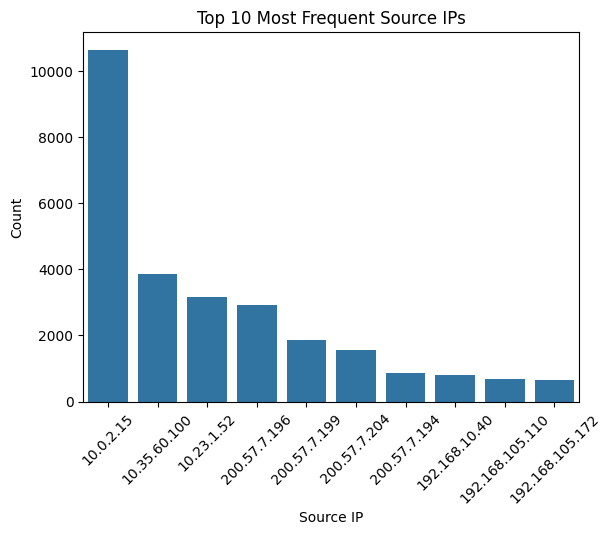

In [6]:
import socket
import struct

# Function to convert byte strings to human-readable IP addresses
def convert_ip(ip_bytes):
    try:
        return socket.inet_ntoa(ip_bytes)
    except:
        return None

# Apply the conversion function to the src_ip column
packet_df['src_ip'] = packet_df['src_ip'].apply(convert_ip)
packet_df['dst_ip'] = packet_df['dst_ip'].apply(convert_ip)

# Remove rows where IP conversion failed (optional, depends on your data)
packet_df = packet_df.dropna(subset=['src_ip', 'dst_ip'])

# Recalculate the IP counts after conversion
ip_counts = packet_df.groupby("src_ip").size().reset_index(name='count').sort_values(by="count", ascending=False)

# Display the top 10 most frequent IPs
print(ip_counts.head(10))

# Plot the top 10 most frequent IPs
sns.barplot(data=ip_counts.head(10), x="src_ip", y="count")
plt.title("Top 10 Most Frequent Source IPs")
plt.xlabel("Source IP")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


# Aggregate Data by Protocol and Time

In [7]:
# Group by time (1-second intervals) and protocol, and sum only the 'bytes' column
agg_df = packet_df.groupby([pd.Grouper(key="time_since_start", freq='1S'), 'protocol'])['bytes'].sum().reset_index()

# Add column for megabits per second
agg_df['Mb/s'] = agg_df['bytes'] * 8 / 1000000

# Convert time_since_start back to total seconds for easier plotting
agg_df['time_since_start'] = agg_df['time_since_start'].dt.total_seconds()

# Display the first few rows of aggregated data
agg_df.head()


,time_since_start,protocol,bytes,Mb/s
0,0.0,Other,176,0.001408
1,0.0,RTP,40150,0.321200
2,0.0,TCP,5302,0.042416
3,0.0,UDP,100808,0.806464
4,1.0,TCP,1646,0.013168


# Visualize Protocol Traffic Over Time

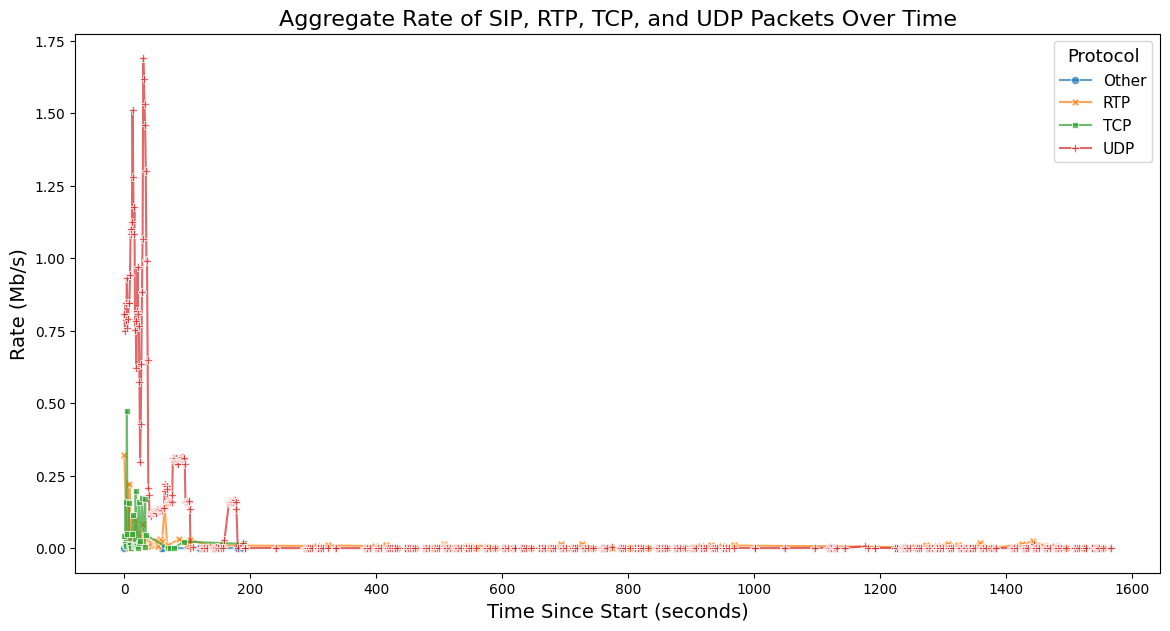

In [8]:
# Increase the plot size
plt.figure(figsize=(14, 7))

# Plot the aggregated data over time with improved readability
sns.lineplot(data=agg_df, x="time_since_start", y="Mb/s", hue="protocol",
             style="protocol", markers=True, dashes=False, alpha=0.7)

# Adjust labels and title
plt.title("Aggregate Rate of SIP, RTP, TCP, and UDP Packets Over Time", fontsize=16)
plt.xlabel("Time Since Start (seconds)", fontsize=14)
plt.ylabel("Rate (Mb/s)", fontsize=14)

# Improve the legend
plt.legend(title='Protocol', title_fontsize='13', fontsize='11')

# Show the plot
plt.show()


# Latency Analysis


In [10]:
""""
import time

# Start timing
start_time = time.time()

# Sample the data more aggressively to reduce memory usage (e.g., 1% of the data)
sampled_packet_df = packet_df.sample(frac=0.01, random_state=42)
print(f"Sampling time: {time.time() - start_time:.2f} seconds")

# Start timing for time delta calculation
start_time = time.time()

# Calculate time delta between packets from the same source IP in the sampled data
sampled_packet_df["time_delta"] = sampled_packet_df.groupby("src_ip")["time"].diff()

# Drop any NaN values resulting from the diff operation
time_deltas = sampled_packet_df["time_delta"].dropna()
print(f"Time delta calculation time: {time.time() - start_time:.2f} seconds")

# Start timing for binning
start_time = time.time()

# Manually aggregate time deltas into bins to avoid memory issues
bin_edges = pd.interval_range(start=pd.Timedelta(seconds=0), freq=pd.Timedelta(seconds=1), end=time_deltas.max())  # Define 1-second bins
binned_deltas = pd.cut(time_deltas, bins=bin_edges)  # Assign deltas to bins
binned_counts = binned_deltas.value_counts().sort_index()  # Count occurrences in each bin
print(f"Binning time: {time.time() - start_time:.2f} seconds")

# Start timing for DataFrame conversion and plotting
start_time = time.time()

# Convert to DataFrame for easier plotting
binned_counts_df = binned_counts.reset_index()
binned_counts_df.columns = ['Time Delta (seconds)', 'Frequency']

# Plot the aggregated histogram
plt.figure(figsize=(12, 6))
sns.barplot(x=binned_counts_df['Time Delta (seconds)'].astype(str), y=binned_counts_df['Frequency'])
plt.title("Histogram of Packet Latency (Time Delta)")
plt.xlabel("Time Delta (seconds)")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

print(f"Plotting time: {time.time() - start_time:.2f} seconds")



SyntaxError: incomplete input (<ipython-input-10-ef0be4030453>, line 1)

# Packet Loss Detection

In [11]:
import numpy as np
packet_df['seq_num'] = np.arange(len(packet_df))  # Replace with actual sequence number extraction
packet_df['seq_num_delta'] = packet_df.groupby('src_ip')['seq_num'].diff()

# Detect gaps in sequence numbers
packet_df['packet_loss'] = packet_df['seq_num_delta'] > 1
loss_df = packet_df[packet_df['packet_loss']]

print(f"Detected {len(loss_df)} instances of packet loss.")
loss_df.head()


Detected 16016 instances of packet loss.


,protocol,time,bytes,src_ip,dst_ip,src_port,dst_port,pcap_file,time_since_start,seq_num,seq_num_delta,packet_loss
4,RTP,2016-12-02 10:41:21.078094848,342,10.0.2.20,10.0.2.15,5060.0,5060.0,sip-rtp-g729a (2).pcap,0 days 00:00:00.007796992,4,4.0,True
5,UDP,2016-12-02 10:41:21.095833088,60,10.0.2.15,10.0.2.20,28120.0,6000.0,sip-rtp-g729a (2).pcap,0 days 00:00:00.025535232,5,2.0,True
432,RTP,2016-12-02 10:41:29.577231872,326,10.0.2.20,10.0.2.15,5060.0,5060.0,sip-rtp-g729a (2).pcap,0 days 00:00:08.506934016,432,428.0,True
434,RTP,2016-11-26 15:03:00.371198976,315,10.0.2.15,10.0.2.20,5060.0,5060.0,sip-rtp-l16 (2).pcap,0 days 00:00:00.000158976,434,3.0,True
437,RTP,2016-11-26 15:03:00.376252928,341,10.0.2.20,10.0.2.15,5060.0,5060.0,sip-rtp-l16 (2).pcap,0 days 00:00:00.005212928,437,4.0,True


In [12]:
def adjust_for_wrap(seq_num_delta, max_seq_num=2**32):
    # Adjust for wrap-around
    return seq_num_delta % max_seq_num


In [13]:
packet_df['is_retransmission'] = packet_df.duplicated(subset=['seq_num', 'src_ip'], keep='first')


In [14]:
packet_df['time_since_last'] = packet_df.groupby('src_ip')['time'].diff()


In [15]:
protocol_packet_loss = packet_df.groupby('protocol')['packet_loss'].sum()
print(protocol_packet_loss)


protocol
Other        7
RTP        285
TCP        731
UDP      14993
Name: packet_loss, dtype: int64
